In [1]:
import pandas as pd
import numpy as np
import cupy
import matplotlib.pyplot as plt
import gc
import os

from dotenv import dotenv_values

In [2]:
config = dotenv_values('../.env')

In [3]:
train = pd.read_parquet(config["INT_TRAIN_PARQUET"])

In [4]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0


In [5]:
VER = 1

SEED = 42

NAN_VALUE = -127

FOLDS = 5

In [6]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 190 columns):
 #    Column       Dtype  
---   ------       -----  
 0    customer_ID  object 
 1    S_2          object 
 2    P_2          float32
 3    D_39         int16  
 4    B_1          float32
 5    B_2          float32
 6    R_1          float32
 7    S_3          float32
 8    D_41         float32
 9    B_3          float32
 10   D_42         float32
 11   D_43         float32
 12   D_44         int8   
 13   B_4          int16  
 14   D_45         float32
 15   B_5          float32
 16   R_2          int8   
 17   D_46         float32
 18   D_47         float32
 19   D_48         float32
 20   D_49         int16  
 21   B_6          float32
 22   B_7          float32
 23   B_8          float32
 24   D_50         float32
 25   D_51         int8   
 26   B_9          float32
 27   R_3          int8   
 28   D_52         float32
 29   P_3          float32
 30   B_10         flo

In [7]:
train.S_2 = pd.to_datetime(train.S_2)

In [8]:
train = train.fillna(NAN_VALUE)

In [9]:
train.isnull().sum()

customer_ID    0
S_2            0
P_2            0
D_39           0
B_1            0
              ..
D_141          0
D_142          0
D_143          0
D_144          0
D_145          0
Length: 190, dtype: int64

In [10]:
# cat_feat = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
# train[cat_feat] = train[cat_feat].astype("category")

In [11]:
# train.info(verbose=True)

In [12]:
def process_and_feature_engineer(df):
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2','target']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]
    
    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    
    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = pd.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df

In [13]:
train = process_and_feature_engineer(train)

shape after engineering (458913, 918)


In [14]:
train.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933824,0.024194,0.868580,0.960384,0.934745,0.230769,0.832050,0,3,0,...,1,13,0,1,13,-1,1,13,6,1
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899820,0.022119,0.861109,0.929122,0.880519,7.153846,6.743468,0,19,6,...,1,13,0,1,13,-1,1,13,6,1
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878454,0.028911,0.797670,0.904482,0.880875,0.000000,0.000000,0,0,0,...,1,13,2,1,13,-1,1,13,6,1
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.598969,0.020107,0.567442,0.623392,0.621776,1.538462,3.017046,0,9,0,...,1,13,0,1,13,-1,1,13,3,3
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891679,0.042325,0.805045,0.940382,0.871900,0.000000,0.000000,0,0,0,...,1,13,0,1,13,1,1,13,6,1


In [15]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Data columns (total 918 columns):
 #    Column         Dtype  
---   ------         -----  
 0    P_2_mean       float32
 1    P_2_std        float64
 2    P_2_min        float32
 3    P_2_max        float32
 4    P_2_last       float32
 5    D_39_mean      float64
 6    D_39_std       float64
 7    D_39_min       int16  
 8    D_39_max       int16  
 9    D_39_last      int16  
 10   B_1_mean       float32
 11   B_1_std        float64
 12   B_1_min        float32
 13   B_1_max        float32
 14   B_1_last       float32
 15   B_2_mean       float32
 16   B_2_std        float64
 17   B_2_min        float32
 18   B_2_max        float32
 19   B_2_last       float32
 20   R_1_mean       float32
 21   R_1_std        float64
 22   R_1_min        float32
 23   R_1_max        float32
 24   R_1_last    

In [16]:
targets = pd.read_csv(config["TRAIN_LABELS_PATH"])
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
# train.target = train.target.astype('category')
del targets

In [17]:
train.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933824,0.024194,0.868580,0.960384,0.934745,0.230769,0.832050,0,3,0,...,13,0,1,13,-1,1,13,6,1,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899820,0.022119,0.861109,0.929122,0.880519,7.153846,6.743468,0,19,6,...,13,0,1,13,-1,1,13,6,1,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878454,0.028911,0.797670,0.904482,0.880875,0.000000,0.000000,0,0,0,...,13,2,1,13,-1,1,13,6,1,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.598969,0.020107,0.567442,0.623392,0.621776,1.538462,3.017046,0,9,0,...,13,0,1,13,-1,1,13,3,3,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891679,0.042325,0.805045,0.940382,0.871900,0.000000,0.000000,0,0,0,...,13,0,1,13,1,1,13,6,1,0


In [18]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Data columns (total 919 columns):
 #    Column         Dtype  
---   ------         -----  
 0    P_2_mean       float32
 1    P_2_std        float64
 2    P_2_min        float32
 3    P_2_max        float32
 4    P_2_last       float32
 5    D_39_mean      float64
 6    D_39_std       float64
 7    D_39_min       int16  
 8    D_39_max       int16  
 9    D_39_last      int16  
 10   B_1_mean       float32
 11   B_1_std        float64
 12   B_1_min        float32
 13   B_1_max        float32
 14   B_1_last       float32
 15   B_2_mean       float32
 16   B_2_std        float64
 17   B_2_min        float32
 18   B_2_max        float32
 19   B_2_last       float32
 20   R_1_mean       float32
 21   R_1_std        float64
 22   R_1_min        float32
 23   R_1_max        float32
 24   R_1_last    

In [19]:
train = train.sort_index().reset_index()
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

There are 918 features!


In [20]:
print(FEATURES)

Index(['P_2_mean', 'P_2_std', 'P_2_min', 'P_2_max', 'P_2_last', 'D_39_mean',
       'D_39_std', 'D_39_min', 'D_39_max', 'D_39_last',
       ...
       'D_63_nunique', 'D_64_count', 'D_64_last', 'D_64_nunique', 'D_66_count',
       'D_66_last', 'D_66_nunique', 'D_68_count', 'D_68_last', 'D_68_nunique'],
      dtype='object', length=918)


In [21]:
# LOAD XGB LIBRARY
from sklearn.model_selection import KFold
import xgboost as xgb
print('XGB Version',xgb.__version__)

# XGB MODEL PARAMETERS
xgb_params = { 
    'max_depth':4, 
    'learning_rate':0.05, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.6.1


In [27]:
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cupy.array(self.df.iloc[a:b].values.tolist())
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [23]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [32]:
import warnings
warnings.filterwarnings('ignore')

importances = []
oof = []
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
#     Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx, 'target']
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    
    dtrain = xgb.DMatrix(data=X_train, label=y_train) # xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    model = xgb.train(xgb_params, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'XGB_v{VER}_fold{fold}.xgb')
    
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
    
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    del X_train, y_train, X_valid, y_valid, model, dd, df
    _ = gc.collect()

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
[0]	train-logloss:0.66203	valid-logloss:0.66207
[100]	train-logloss:0.23677	valid-logloss:0.23956
[200]	train-logloss:0.22236	valid-logloss:0.22755
[300]	train-logloss:0.21638	valid-logloss:0.22374
[400]	train-logloss:0.21222	valid-logloss:0.22161
[500]	train-logloss:0.20909	valid-logloss:0.22051
[600]	train-logloss:0.20636	valid-logloss:0.21976
[700]	train-logloss:0.20391	valid-logloss:0.21926
[800]	train-logloss:0.20155	valid-logloss:0.21883
[900]	train-logloss:0.19938	valid-logloss:0.21855
[1000]	train-logloss:0.19735	valid-logloss:0.21835
[1100]	train-logloss:0.19538	valid-logloss:0.21819
[1200]	train-logloss:0.19346	valid-logloss:0.21801
[1300]	train-logloss:0.19157	valid-logloss:0.21789
[1400]	train-logloss:0.18971	valid-logloss:0.21786
[1500]	train-logloss:0.18790	valid-logloss:0.21785
[1516]	train-logloss:0.18763	valid-logloss:0.21786
Kaggle 

In [35]:
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric =',acc)

#########################
OVERALL CV Kaggle Metric = 0.7915479085459058


In [37]:
oof_xgb = pd.read_parquet(config["INT_TRAIN_PARQUET"], columns=['customer_ID']).drop_duplicates()
# oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
oof_xgb = oof_xgb.set_index('customer_ID')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)
oof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)
oof_xgb.head()

,target,oof_pred
0,0,0.000536
1,0,0.001410
2,0,0.001059
3,0,0.009082
4,0,0.001818


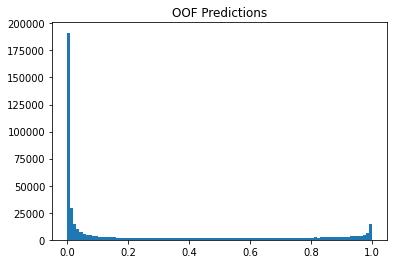

In [38]:
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

In [39]:
import matplotlib.pyplot as plt

df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

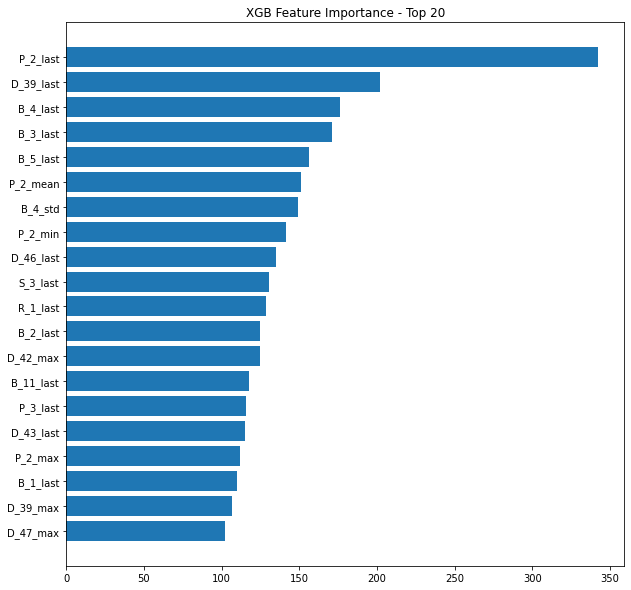

In [40]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

In [41]:
del oof_xgb, oof, train
_ = gc.collect()

In [51]:
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4
# TEST_PATH = '../input/amex-data-integer-dtypes-parquet-format/test.parquet'

print(f'Reading test data...')
test = pd.read_parquet(config["INT_TEST_PARQUET"], columns=['customer_ID','S_2'])
test.S_2 = pd.to_datetime(test.S_2)
test = test.fillna(NAN_VALUE)

customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

Reading test data...
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2841209, 2839857, 2842105, 2840591]


In [52]:
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = pd.read_parquet(config["INT_TEST_PARQUET"])
    test.S_2 = pd.to_datetime(test.S_2)
    test = test.fillna(NAN_VALUE)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = process_and_feature_engineer(test)
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    test = test[['P_2_mean']] # reduce memory
    del X_test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'XGB_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'XGB_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()


Reading test data...
=> Test part 1 has shape (2841209, 190)
shape after engineering (231155, 918)

Reading test data...
=> Test part 2 has shape (2839857, 190)
shape after engineering (231155, 918)

Reading test data...
=> Test part 3 has shape (2842105, 190)
shape after engineering (231155, 918)

Reading test data...
=> Test part 4 has shape (2840591, 190)
shape after engineering (231156, 918)


In [54]:
test_preds = np.concatenate(test_preds)
test = pd.DataFrame(index=customers,data={'prediction':test_preds})
sub = pd.read_csv(config["SAMPLE_PATH"])[['customer_ID']]
# sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index()

# DISPLAY PREDICTIONS
sub.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.035991
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001116
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.061794
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.257451
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.852345


In [53]:
# test_preds.shape

AttributeError: 'list' object has no attribute 'shape'

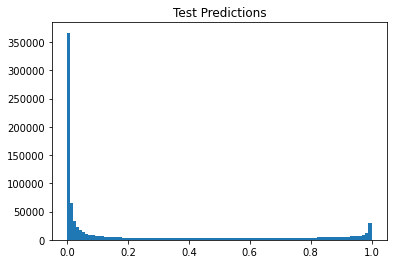

In [57]:
plt.hist(sub.prediction.values, bins=100)
plt.title('Test Predictions')
plt.show()

In [56]:
sub.to_csv(f'submission_xgb_v{VER}.csv',index=False)
print('Submission file shape is', sub.shape )

Submission file shape is (924621, 2)
